This is not the latest version, the latest version is in the hard drive. I will update it afterwards

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import keras 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform
from PIL import Image


2024-12-17 12:39:52.182381: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 12:39:52.206574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 12:39:52.206599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 12:39:52.207386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 12:39:52.211788: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set the environment variable to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
#labels_df = pd.read_csv("/home/elahed/users/elahe/Automatic-Data-Collector/output_town04/scaled_filtered_control_commands_data_with_class.csv")
#images_directory = '/home/elahed/users/elahe/Automatic-Data-Collector/output_town04/front_rgb/'

labels_df = pd.read_csv("/home/elahed/users/elahe/project_with_aws/output_front/augmented_scaled_steering_data_with_class.csv")
images_directory = '/home/elahed/users/elahe/project_with_aws/output_front/augment/'

labels = []
image_path = []
Image_and_label = []
steering_labels = []
# Iterate through the rows of the DataFrame
for index, row in labels_df.iterrows():
    labels.append(row['Steering'])
    steering_labels.append(row['Steering_Class'])
    #image_path.append(os.path.join(images_directory, row['Image_Fname']+'.png'))  # Replace with the actual column name
    image_path.append(os.path.join(images_directory, row['Image_Fname']))  # Replace with the actual column name
    #Image_and_label.append([os.path.join(images_directory, row['Image_Fname']+'.png'),row['Steering'],row['Throttle'],row['Brake']])

In [4]:
print(labels)

[-0.842894375324249, 0.842894375324249, -0.910610496997833, 0.910610496997833, -0.891366422176361, 0.891366422176361, -0.918736040592194, 0.918736040592194, -0.810523986816406, 0.810523986816406, -0.801967740058899, 0.801967740058899, -0.815046429634094, 0.815046429634094, -0.943904519081116, 0.943904519081116, -0.829629242420196, 0.829629242420196, -0.815295100212097, 0.815295100212097, -0.936198830604553, 0.936198830604553, -0.820551455020904, 0.820551455020904, -0.806955814361572, 0.806955814361572, -0.816531121730804, 0.816531121730804, -0.944426476955413, 0.944426476955413, -0.828039109706878, 0.828039109706878, -0.808024406433105, 0.808024406433105, -0.922617256641388, 0.922617256641388, -0.804367363452911, 0.804367363452911, -0.918022334575653, 0.918022334575653, -0.805862724781036, 0.805862724781036, -0.907363831996918, 0.907363831996918, -0.900232553482056, 0.900232553482056, -0.916440963745117, 0.916440963745117, -0.805272161960601, 0.805272161960601, -0.909316480159759, 0.90

In [5]:
print(steering_labels)

[1, 18, 0, 19, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 0, 19, 1, 18, 0, 19, 1, 18, 0, 19, 0, 19, 0, 19, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 0, 19, 0, 19, 1, 18, 0, 19, 0, 19, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 0, 19, 0, 19, 1, 18, 0, 19, 0, 19, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 0, 19, 0, 19, 1, 18, 0, 19, 0, 19, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 1, 18, 0, 19, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 1, 18, 0, 19

In [ ]:
#### Code for discretizing the steering values ####
'''
import numpy as np
import pandas as pd

# Load the dataset
file_path = "/home/elahed/users/elahe/Automatic-Data-Collector/output_town04/scaled_filtered_control_commands.csv"
data = pd.read_csv(file_path)


# Define the custom intervals and class labels
custom_intervals = [
    -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,
    0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1
]  # 21 endpoints for 20 intervals

custom_labels = list(range(0, len(custom_intervals)-1))  # Classes 1 to 20 changed to 0 to 19

# Assign each steering value to a class based on the intervals
data['Steering_Class'] = pd.cut(
    data['Steering'],
    bins=custom_intervals,
    labels=custom_labels,
    include_lowest=True
)



# Save the updated dataset
output_path = '/home/elahed/users/elahe/Automatic-Data-Collector/output_town04/scaled_filtered_control_commands_data_with_class.csv'
data.to_csv(output_path, index=False)

# Print a preview
#print(data[['Steering', 'Steering_Class']].head())


# Validate the class range
print(f"Classes range: {data['Steering_Class'].min()} to {data['Steering_Class'].max()}")

'''

Classes range: 0 to 19


In [6]:
len(labels)

75214

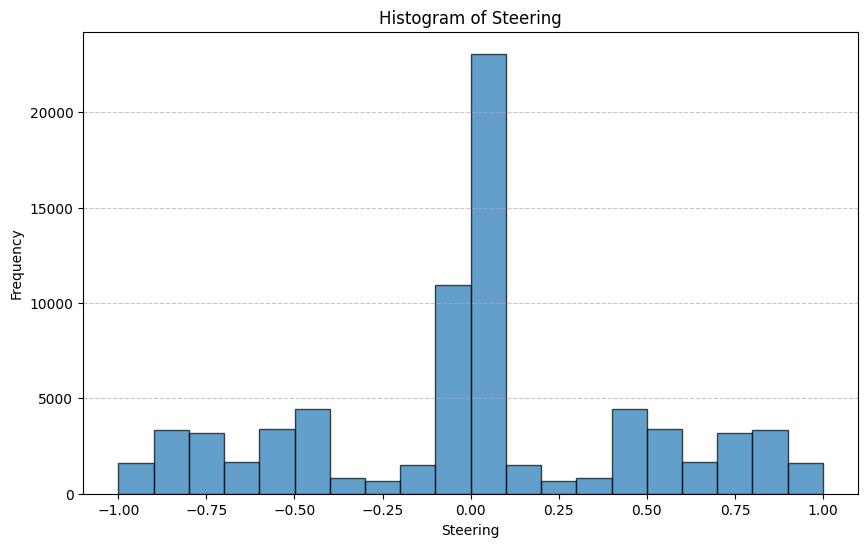

In [7]:
import matplotlib.pyplot as plt

# Plot the histogram for the 'Steering' column
column_name = 'Steering'

plt.figure(figsize=(10, 6))
plt.hist(labels_df[column_name], bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of {column_name}")
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [8]:
def flipping(img, steering):
    flip_image = cv2.flip(img,1)
    flip_steering = steering*-1.0
    return flip_image, flip_steering

def brightness(img,steering):
    bright_limit = (-0.5, 0.15)
    brightness_multiplier = 1.0 + np.random.uniform(low=bright_limit[0], high=bright_limit[1])
    image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image_hsv[:,:,2] = image_hsv[:,:,2] * brightness_multiplier
    bright_image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return bright_image , steering

In [9]:
class My_Custom_Generator1(keras.utils.Sequence):
  
    def __init__(self, image_filenames, labels, class_labels, batch_size, augment,crop_coords=None):
        """
        Initialize the custom generator.

        Args:
        - image_filenames: List of file paths to images.
        - labels: List of continuous steering values.
        - class_labels: List of discretized class labels corresponding to the steering values.
        - batch_size: Batch size for the generator.
        - augment: List of augmentation options (e.g., ['Flip', 'bright']).
        """
        self.image_filenames = image_filenames
        self.labels = labels  # Continuous steering values
        self.class_labels = class_labels  # Discretized class labels
        self.batch_size = batch_size
        self.augment = augment
        self.crop_coords = crop_coords
    
    def __len__(self):
        """
        Return the number of batches per epoch.
        """
        return (np.floor(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)
  
    def __getitem__(self, idx):
        """
        Generate a batch of data.
        """
        # Get the batch data
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y_continuous = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y_classes = self.class_labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        inputs = []
        outputs_continuous = []
        outputs_classes = []

        # Process each image and label in the batch
        for filename, continuous, class_label in zip(batch_x, batch_y_continuous, batch_y_classes):
            try:
                # Load the image
                img = Image.open(filename)
                
                # Convert to RGB to ensure consistent channels
                img = img.convert("RGB")
                
                # Apply cropping if specified
                if self.crop_coords:
                    left, top, right, bottom = self.crop_coords
                else:
                    left, top, right, bottom = 0, 255, 448, 448  # Default cropping values
                img = img.crop((left, top, right, bottom))

                # Convert to NumPy array and resize
                img = np.array(img)
                img_resized = cv2.resize(img, (160, 160))
                inputs.append(img_resized)
                outputs_continuous.append(continuous)
                outputs_classes.append(class_label)

                # Apply augmentations
                if self.augment[0] == 'Flip':
                    aug_image, aug_steer = flipping(img_resized, continuous)
                    inputs.append(aug_image)
                    outputs_continuous.append(aug_steer)
                    outputs_classes.append(class_label)  # Augmentation doesn't change class label

                if self.augment[1] == 'bright':
                    aug_image, aug_steer = brightness(img_resized, continuous)
                    inputs.append(aug_image)
                    outputs_continuous.append(aug_steer)
                    outputs_classes.append(class_label)  # Augmentation doesn't change class label

            except Exception as e:
                print(f"Skipping file {filename} due to error: {e}")
            


        # Convert inputs and outputs to numpy arrays
        inputs_final = np.array(inputs).astype("float32") / 255.0  # Normalize images
        outputs_continuous = np.array(outputs_continuous).astype("float32")
        outputs_classes = np.array(outputs_classes).astype("int32")  # Ensure class labels are integers
            # Validate inputs and labels
        if np.any(np.isnan(inputs_final)) or np.any(np.isinf(inputs_final)):
            raise ValueError("NaN or Inf detected in input images!")

        if np.any(np.isnan(outputs_continuous)) or np.any(np.isinf(outputs_continuous)):
            raise ValueError("NaN or Inf detected in continuous labels!")

        if np.any(np.isnan(outputs_classes)) or np.any(np.isinf(outputs_classes)):
            raise ValueError("NaN or Inf detected in discrete labels!")

        # Return inputs and both outputs
        #return inputs_final, {"continuous_output": outputs_continuous, "discrete_output": outputs_classes}
        return inputs_final, [outputs_continuous , outputs_classes]


In [10]:
batch_size = 32
# Combine labels and class_labels for consistent splitting
combined_labels = list(zip(labels, steering_labels))
X_train_data, X_valid_data, combined_train_labels, combined_valid_labels = train_test_split(image_path,combined_labels, test_size=0.1,shuffle=True)
#X_train_data, X_valid_data, combined_train_labels, combined_valid_labels = train_test_split(image_path,combined_labels, test_size=0.1,shuffle=False)
# Separate continuous and class labels after the split
y_train_continuous, y_train_classes = zip(*combined_train_labels)
y_valid_continuous, y_valid_classes = zip(*combined_valid_labels)
train_generator = My_Custom_Generator1(X_train_data, y_train_continuous,y_train_classes, batch_size,augment =["no","bright"] )
valid_generator = My_Custom_Generator1(X_valid_data, y_valid_continuous,y_valid_classes, batch_size,augment =["no","bright"] )

In [11]:
#### for test with all data
'''
batch_size = 32
# Combine labels and class_labels for consistent splitting
train_generator = My_Custom_Generator1(image_path, labels, steering_labels, batch_size,augment =["no","bright"] )
'''

'\nbatch_size = 32\n# Combine labels and class_labels for consistent splitting\ntrain_generator = My_Custom_Generator1(image_path, labels, steering_labels, batch_size,augment =["no","bright"] )\n'

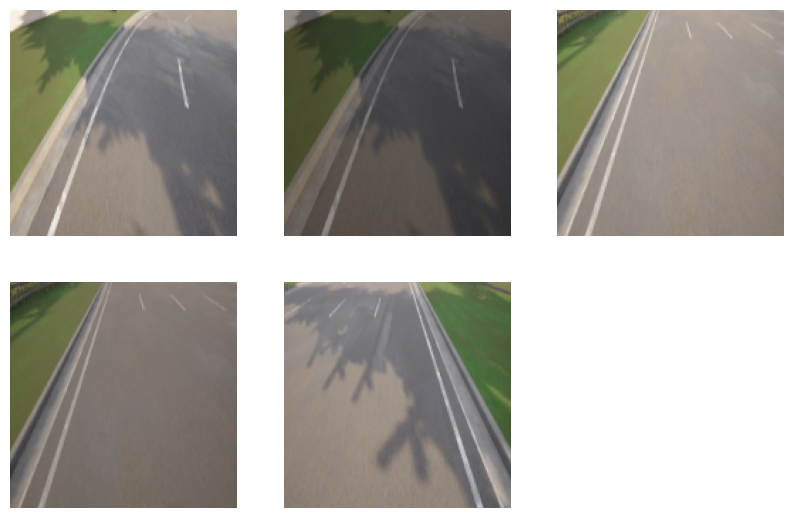

In [11]:
# Generate and plot 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    augmented_image = train_generator[0][0][i]
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.show()

In [12]:
train_generator[0][1][0]

array([ 8.1648678e-01,  8.1648678e-01,  1.2313407e-03,  1.2313407e-03,
        0.0000000e+00,  0.0000000e+00,  1.6558383e-01,  1.6558383e-01,
       -7.0293248e-04, -7.0293248e-04,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -2.4622418e-03, -2.4622418e-03,
        0.0000000e+00,  0.0000000e+00,  1.2175147e-03,  1.2175147e-03,
       -4.8174003e-01, -4.8174003e-01, -2.4622418e-03, -2.4622418e-03,
        0.0000000e+00,  0.0000000e+00, -1.0966675e-01, -1.0966675e-01,
        8.1893045e-01,  8.1893045e-01,  0.0000000e+00,  0.0000000e+00,
       -3.2051608e-01, -3.2051608e-01, -5.3567016e-01, -5.3567016e-01,
       -5.3583777e-01, -5.3583777e-01,  1.7218259e-03,  1.7218259e-03,
       -5.8904670e-02, -5.8904670e-02,  0.0000000e+00,  0.0000000e+00,
        7.8301567e-01,  7.8301567e-01, -6.1975503e-01, -6.1975503e-01,
       -8.0923814e-01, -8.0923814e-01,  1.7729118e-02,  1.7729118e-02,
        0.0000000e+00,  0.0000000e+00, -9.3578041e-02, -9.3578041e-02,
      

In [13]:
len(X_train_data)

67692

In [14]:
X_train_data

['/home/elahed/users/elahe/project_with_aws/output_front/augment/flipped_image_2024-12-11-23-49_00097908.png',
 '/home/elahed/users/elahe/project_with_aws/output_front/augment/flipped_image_2024-12-12-02-30_00191758.png',
 '/home/elahed/users/elahe/project_with_aws/output_front/augment/unflipped_image_2024-12-12-03-41_00232453.png',
 '/home/elahed/users/elahe/project_with_aws/output_front/augment/flipped_image_2024-12-12-03-15_00217544.png',
 '/home/elahed/users/elahe/project_with_aws/output_front/augment/flipped_image_2024-12-11-22-12_00041685.png',
 '/home/elahed/users/elahe/project_with_aws/output_front/augment/flipped_image_2024-12-12-02-14_00182052.png',
 '/home/elahed/users/elahe/project_with_aws/output_front/augment/unflipped_image_2024-12-12-04-42_00268054.png',
 '/home/elahed/users/elahe/project_with_aws/output_front/augment/flipped_image_2024-12-12-00-51_00133639.png',
 '/home/elahed/users/elahe/project_with_aws/output_front/augment/unflipped_image_2024-12-12-04-19_00254329.p

In [15]:
y_train_continuous

(0.816486775875092,
 0.001231340691447,
 0.0,
 0.165583834052086,
 -0.000702932476997,
 0.0,
 0.0,
 -0.002462241798639,
 0.0,
 0.001217514742166,
 -0.481740027666092,
 -0.002462241798639,
 0.0,
 -0.109666749835014,
 0.818930447101593,
 0.0,
 -0.32051607966423,
 -0.535670161247253,
 -0.535837769508362,
 0.00172182591632,
 -0.05890467017889,
 0.0,
 0.783015668392181,
 -0.619755029678344,
 -0.809238135814667,
 0.017729118466377,
 0.0,
 -0.093578040599823,
 -0.946377217769623,
 -0.741928398609161,
 0.014564033597708,
 0.0,
 -0.001231340691447,
 -0.001468145404942,
 -0.400337338447571,
 0.514175057411194,
 0.000351246417267,
 0.773366749286652,
 -0.002462241798639,
 -0.049818150699138,
 0.0,
 -0.000702932476997,
 0.045740850269794,
 -0.159510433673858,
 -0.763961732387542,
 -0.407178401947021,
 0.000734603323508,
 0.941594362258911,
 0.817321538925171,
 0.017555253580212,
 0.668903827667236,
 0.0,
 0.808436274528503,
 -0.368020683526993,
 -0.487243682146072,
 0.0,
 0.001759309438057,
 0.0,


In [16]:
y_train_classes

(18,
 10,
 9,
 11,
 9,
 9,
 9,
 9,
 9,
 10,
 5,
 9,
 9,
 8,
 18,
 9,
 6,
 4,
 4,
 10,
 9,
 9,
 17,
 3,
 1,
 10,
 9,
 9,
 0,
 2,
 10,
 9,
 9,
 9,
 5,
 15,
 10,
 17,
 9,
 9,
 9,
 9,
 10,
 8,
 2,
 5,
 10,
 19,
 18,
 10,
 16,
 9,
 18,
 6,
 5,
 9,
 10,
 9,
 8,
 1,
 8,
 8,
 9,
 8,
 10,
 14,
 9,
 9,
 9,
 3,
 2,
 10,
 10,
 9,
 14,
 4,
 15,
 5,
 4,
 11,
 9,
 9,
 11,
 14,
 9,
 14,
 7,
 10,
 9,
 15,
 13,
 9,
 5,
 9,
 10,
 18,
 9,
 9,
 10,
 9,
 14,
 10,
 16,
 10,
 9,
 19,
 9,
 9,
 9,
 2,
 9,
 9,
 2,
 9,
 9,
 9,
 5,
 15,
 9,
 0,
 4,
 14,
 9,
 9,
 8,
 17,
 2,
 5,
 9,
 15,
 9,
 5,
 9,
 14,
 9,
 14,
 9,
 9,
 9,
 2,
 10,
 17,
 15,
 9,
 15,
 8,
 9,
 9,
 5,
 15,
 9,
 9,
 16,
 9,
 9,
 14,
 19,
 0,
 10,
 1,
 10,
 11,
 9,
 9,
 16,
 19,
 15,
 10,
 10,
 10,
 14,
 4,
 16,
 4,
 10,
 5,
 5,
 9,
 5,
 10,
 2,
 19,
 11,
 2,
 15,
 9,
 18,
 15,
 10,
 9,
 18,
 1,
 2,
 2,
 9,
 1,
 9,
 10,
 1,
 17,
 15,
 16,
 1,
 9,
 5,
 9,
 17,
 9,
 1,
 9,
 16,
 2,
 2,
 14,
 3,
 10,
 9,
 14,
 1,
 9,
 10,
 18,
 9,
 9,
 15,
 9,
 10,
 15,

In [17]:
for i in y_train_classes:
    if i>19 or i<0:
        print("wrong")

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def get_resnet_model_with_two_outputs():
    # Input Layer
    inputs_img = Input(shape=(160, 160, 3), name='input_image')

    # ResNet-50 Backbone (Pre-trained on ImageNet)
    # Include top=False to exclude the final classification head.
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs_img, input_shape=(160, 160, 3))

    # Freeze initial ResNet layers (optional, for transfer learning)
    for layer in base_model.layers[:143]:  # Fine-tune from block4 onwards
        layer.trainable = False

    # Add Custom Layers for Regression and Classification
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)  # Global average pooling for reduced dimensionality
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(rate=0.2, name='dropout2')(x)
    x = Dense(256, activation='relu', name='fc3')(x)
    x = Dense(100, activation='relu', name='fc4')(x)
    x = Dense(50, activation='relu', name='fc5')(x)
    x = Dense(10, activation='relu', name='fc6')(x)

    # Continuous Output for Steering Value
    continuous_output = Dense(1,activation='tanh', name='continuous_output')(x)

    # Discrete Output for Steering Classes
    num_classes = 20  # Assuming 20 classes for steering
    discrete_output = Dense(num_classes, activation='softmax', name='discrete_output')(x)

    # Define the Model with Two Outputs
    model = Model(inputs=inputs_img, outputs=[continuous_output, discrete_output])

    return model

# Create and summarize the model
IL_model = get_resnet_model_with_two_outputs()
IL_model.summary()

2024-12-17 12:40:24.646170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-17 12:40:24.668226: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-17 12:40:24.668369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_image[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [19]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(IL_model, to_file='model_discrete.pdf', show_shapes=True, show_layer_names=True)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint directory and file format
#checkpoint_path = 'IL_model_22_all_plus_3000_retrain_turn_only_then_back_into_lane_ckpt.10-0.003.h5'
#IL_model.load_weights(checkpoint_path)

In [21]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.96
)
optimizer_mine = keras.optimizers.Adam(learning_rate=lr_schedule)
'''
# Create the Adam optimizer with gradient clipping
optimizer_mine = Adam(
    learning_rate=lr_schedule,
    clipnorm=1.0  # Clip gradients with norm greater than 1.0
    # Alternatively, you can use clipvalue:
    # clipvalue=0.5  # Clip gradient values to be within [-0.5, 0.5]
)
'''

2024-12-17 12:40:32.178522: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


'\n# Create the Adam optimizer with gradient clipping\noptimizer_mine = Adam(\n    learning_rate=lr_schedule,\n    clipnorm=1.0  # Clip gradients with norm greater than 1.0\n    # Alternatively, you can use clipvalue:\n    # clipvalue=0.5  # Clip gradient values to be within [-0.5, 0.5]\n)\n'

In [22]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Specify the directory where TensorBoard logs will be stored
log_dir = "town06_all_bs32_resnet_both_all_town_tanh"

# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Checkpoint to save the best weights
model_ckpt_name = "IL_model_bs32_resnet_both_all_town_tanh"
checkpoint = ModelCheckpoint(model_ckpt_name + '_best.h5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Early stopping with restore_best_weights enabled
patience = 10
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=patience, 
                          verbose=1, 
                          mode='min', 
                          restore_best_weights=True)

# Combine all callbacks
callbacks = [checkpoint, earlystop, tensorboard_callback]

# Compile the model with SparseCategoricalCrossentropy for discrete_output
IL_model.compile(
    optimizer=optimizer_mine,
    loss={
        'continuous_output': 'mse',
        'discrete_output': SparseCategoricalCrossentropy(from_logits=False),
    },
    loss_weights={
        'continuous_output': 0.5,  # Weight for continuous output
        'discrete_output': 0.5,   # Weight for discrete output
    },
    metrics={
        'continuous_output': ['mae'],
        'discrete_output': ['accuracy'],
    }
)


# Train the model
train_hist = IL_model.fit(
    train_generator,  
    steps_per_epoch=len(X_train_data) // batch_size, 
    epochs=500, 
    validation_data=valid_generator,
    validation_steps=len(X_valid_data) // batch_size,
    shuffle=True,
    verbose=1, 
    callbacks=callbacks#,
    #use_multiprocessing=True,
    #workers=8
)


Epoch 1/500


2024-12-17 12:40:37.806288: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-17 12:40:37.865733: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 12:40:41.431238: I external/local_xla/xla/service/service.cc:168] XLA service 0x55d9b0474f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-17 12:40:41.431260: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-17 12:40:41.434998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734457241.492732 3438764 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2115/2115 [==============================] - ETA: 0s - loss: 1.0351 - continuous_output_loss: 0.0468 - discrete_output_loss: 2.0234 - continuous_output_mae: 0.1619 - discrete_output_accuracy: 0.3335
Epoch 1: val_loss improved from inf to 1.00288, saving model to IL_model_bs32_resnet_both_all_town_tanh_best.h5


/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2115/2115 [==============================] - 475s 220ms/step - loss: 1.0351 - continuous_output_loss: 0.0468 - discrete_output_loss: 2.0234 - continuous_output_mae: 0.1619 - discrete_output_accuracy: 0.3335 - val_loss: 1.0029 - val_continuous_output_loss: 0.0374 - val_discrete_output_loss: 1.9684 - val_continuous_output_mae: 0.1312 - val_discrete_output_accuracy: 0.3530
Epoch 2/500
2115/2115 [==============================] - ETA: 0s - loss: 0.9288 - continuous_output_loss: 0.0364 - discrete_output_loss: 1.8213 - continuous_output_mae: 0.1399 - discrete_output_accuracy: 0.3807
Epoch 2: val_loss did not improve from 1.00288
2115/2115 [==============================] - 457s 216ms/step - loss: 0.9288 - continuous_output_loss: 0.0364 - discrete_output_loss: 1.8213 - continuous_output_mae: 0.1399 - discrete_output_accuracy: 0.3807 - val_loss: 1.0172 - val_continuous_output_loss: 0.0491 - val_discrete_output_loss: 1.9852 - val_continuous_output_mae: 0.1579 - val_discrete_output_accuracy: 0.3

In [23]:
IL_model.save('IL_town06_steer_bs_32_resnet_both_all_town_tanh.keras')
IL_model.save('IL_town06_steer_bs_32_resnet_both_all_town_tanh.h5')

### Load the model and do the test

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('IL_town06_steer_bs_32_resnet_both_all_town_tanh.h5')

# Confirm the model is loaded successfully
model.summary()


2024-12-17 11:02:22.893634: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-17 11:02:22.914912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-17 11:02:22.915038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_image[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

2024-12-17 11:02:27.578491: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-17 11:02:27.624002: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 14ms/step


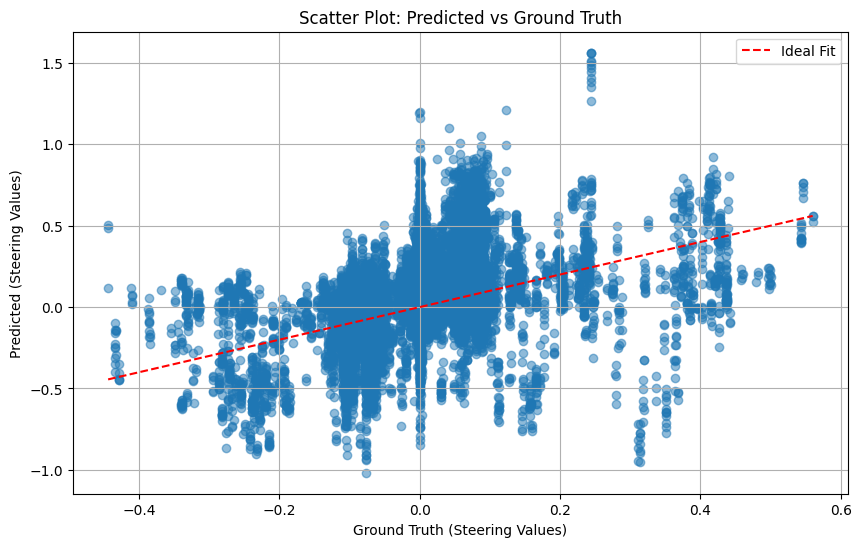

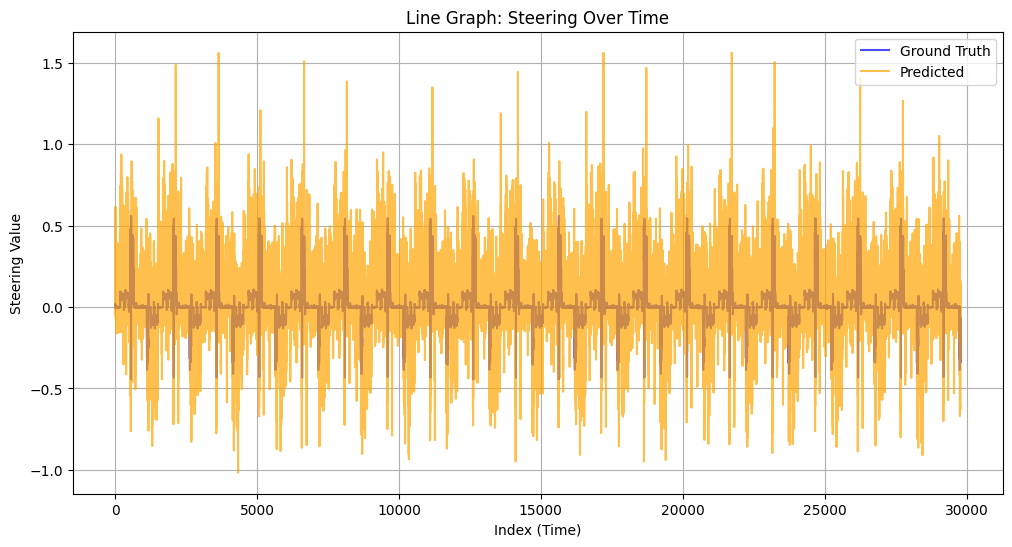

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a trained model `model`
# Get predictions and ground truth from the validation generator
predicted_values = []
ground_truth_values = []

for i in range(len(valid_generator)):
    X_valid, y_valid = valid_generator[i]
    predictions = model.predict(X_valid)
    continuous_output, discrete_output= model.predict(X_valid)
    y_valid_continuous , y_valid_discrete = y_valid
    
    # Append predictions and ground truth
    predicted_values.extend(continuous_output.flatten())  # Flatten to a 1D list
    ground_truth_values.extend(y_valid_continuous.flatten())

# Convert to NumPy arrays for consistency
predicted_values = np.array(predicted_values)
ground_truth_values = np.array(ground_truth_values)

# 1. Scatter Plot: Predicted vs Ground Truth
plt.figure(figsize=(10, 6))
plt.scatter(ground_truth_values, predicted_values, alpha=0.5)
plt.plot([ground_truth_values.min(), ground_truth_values.max()], 
         [ground_truth_values.min(), ground_truth_values.max()], 
         color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Ground Truth (Steering Values)")
plt.ylabel("Predicted (Steering Values)")
plt.title("Scatter Plot: Predicted vs Ground Truth")
plt.legend()
plt.grid()
plt.show()

# 2. Line Graph: Steering Over Time
plt.figure(figsize=(12, 6))
plt.plot(ground_truth_values, label="Ground Truth", color="blue", alpha=0.7)
plt.plot(predicted_values, label="Predicted", color="orange", alpha=0.7)
plt.xlabel("Index (Time)")
plt.ylabel("Steering Value")
plt.title("Line Graph: Steering Over Time")
plt.legend()
plt.grid()
plt.show()


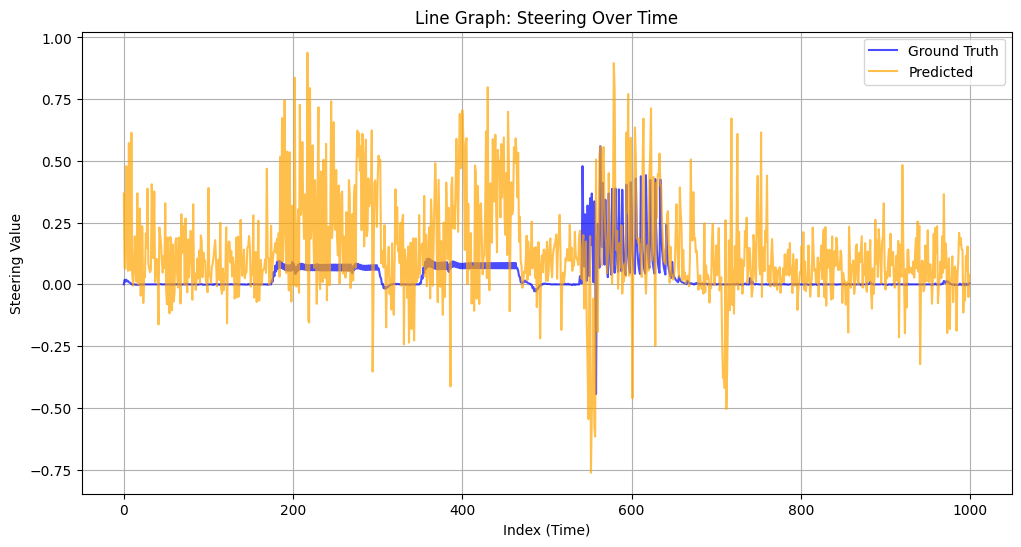

In [11]:
# 2. Line Graph: Steering Over Time
plt.figure(figsize=(12, 6))
plt.plot(ground_truth_values[0:1000], label="Ground Truth", color="blue", alpha=0.7)
plt.plot(predicted_values[0:1000], label="Predicted", color="orange", alpha=0.7)
plt.xlabel("Index (Time)")
plt.ylabel("Steering Value")
plt.title("Line Graph: Steering Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
labels_df['Steering']

In [ ]:
# Predict in batches
predicted_values, predicted_classes = model.predict(train_generator, steps=len(image_path) // batch_size + 1, verbose=1)

1479/1479 [==============================] - 378s 256ms/step


In [ ]:
predicted_values[0]

array([-0.02812407], dtype=float32)

In [ ]:
predicted_classes[0]

array([3.8190058e-07, 3.5623913e-07, 1.3229807e-06, 6.8321965e-06,
       3.2097243e-05, 2.7342667e-04, 1.9090142e-03, 5.9173289e-03,
       1.2420914e-02, 5.5183981e-02, 6.5844011e-01, 2.3646146e-01,
       1.5738178e-02, 8.5843280e-03, 3.8112693e-03, 9.4521546e-04,
       2.1144036e-04, 3.4541550e-05, 2.4589774e-05, 3.1833536e-06],
      dtype=float32)

In [ ]:
# Store predictions in the dataset
labels_df['predicted_steering']= predicted_values[:len(image_path)]

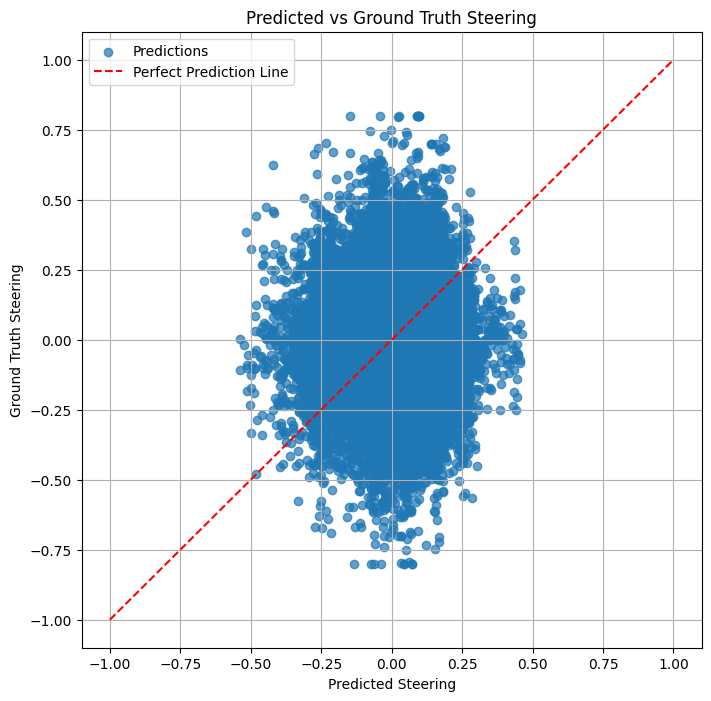

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


##### Scatter Plot: Predicted vs Ground Truth #####

ground_truth = labels_df['Steering']
predicted = labels_df['predicted_steering']   # Replace with your predicted data

plt.figure(figsize=(8, 8))
plt.scatter(predicted, ground_truth, alpha=0.7, label="Predictions")
plt.plot([-1, 1], [-1, 1], 'r--', label="Perfect Prediction Line")  # Diagonal line
plt.xlabel("Predicted Steering")
plt.ylabel("Ground Truth Steering")
plt.title("Predicted vs Ground Truth Steering")
plt.legend()
plt.grid()
plt.show()

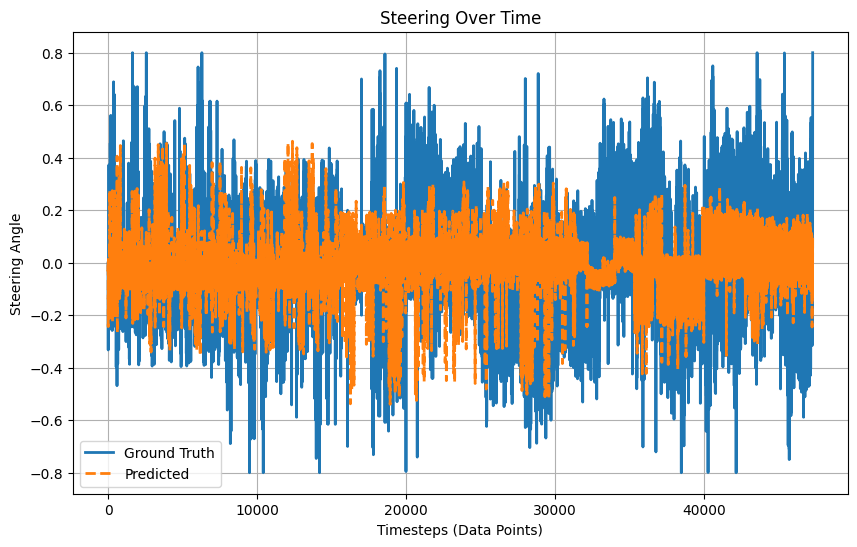

In [ ]:
##### Line Graph: Steering Over Time ######

timesteps = np.arange(len(ground_truth))  # Replace with your actual timesteps
plt.figure(figsize=(10, 6))
plt.plot(timesteps, ground_truth, label="Ground Truth", linewidth=2)
plt.plot(timesteps, predicted, label="Predicted", linestyle="dashed", linewidth=2)
plt.xlabel("Timesteps (Data Points)")
plt.ylabel("Steering Angle")
plt.title("Steering Over Time")
plt.legend()
plt.grid()
plt.show()